# 產生投手數據

In [16]:
# 準備一張投球起手姿勢的圖片,準備一張投球起手結束的圖片
# 利用mediapipe偵測骨架位置得到33個關節的xyz座標(33,3)的數據命名為reference_pose_start,reference_pose_end
# 跑一個函數generate_pose_data(input_path,reference_pose_start,reference_pose_end,output_path)#input_path是投球的影片是一個mp4檔案
# 函數generate_pose_data的功能是在原始影片上渲染mediapipe 3D骨架圖以及當前動作跟reference_pose_start和reference_pose_end的相似度並即時播放渲染後的影片

# 根據專業人士 定義何謂標準的投球起手姿勢 和 投球結束姿勢 當作樣板參考

In [102]:
from mediapipe import solutions as mp_solutions
import cv2
import numpy as np
import mediapipe as mp

mp_drawing = mp_solutions.drawing_utils

def draw_pose_on_image(image_path):
    image = cv2.imread(image_path)
    with mp_pose.Pose(static_image_mode=True) as pose:
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.imshow("Pose Landmarks", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
draw_pose_on_image('pose_start.JPG')
draw_pose_on_image('pose_end.JPG')

In [103]:
import cv2
import numpy as np
import mediapipe as mp

mp_pose = mp.solutions.pose

def extract_reference_pose(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    with mp_pose.Pose(static_image_mode=True) as pose:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if not results.pose_world_landmarks:
            raise ValueError("Pose landmarks not detected in the image.")

        landmarks = results.pose_world_landmarks.landmark
        pose_array = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])  # (33, 3)
        return pose_array
reference_pose_start = extract_reference_pose('pose_start.JPG')
reference_pose_end = extract_reference_pose('pose_end.JPG')
print(reference_pose_start.shape,reference_pose_end.shape)

(33, 3) (33, 3)


In [112]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
def normalize_pose_landmarks_3d(landmarks):
    coords = landmarks

    # 1. 使用左右髖關節的中點作為中心點
    center = coords[0]#(coords[23] + coords[24]) / 2  # left_hip (23), right_hip (24)
    coords -= center  # 平移整個骨架

    # 2. 做尺度正規化（以最大歐氏距離來正規化）
    max_dist = np.linalg.norm(coords, axis=1).max()
    if max_dist > 0:
        coords /= max_dist

    return coords  # shape (33, 3)

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def compute_similarity(pose1, pose2):
    if pose1.shape != (33, 3) or pose2.shape != (33, 3):
        return 0.0
    dist = np.linalg.norm(pose1 - pose2)
    ref_dist = np.linalg.norm(pose2)
    return max(0.0, 1 - dist / (ref_dist + 1e-5))  # avoid divide by zero

def extract_pose_landmarks(results):
    if not results.pose_world_landmarks:
        return None
    landmarks = results.pose_world_landmarks.landmark
    return np.array([[lm.x, lm.y, lm.z] for lm in landmarks])

def generate_pose_data(input_path, reference_pose_start, reference_pose_end, output_path):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    history = {'raw': [], 'processed': []}
    with mp_pose.Pose(static_image_mode=False) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame color
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # 取得 3D 姿勢資訊
            landmarks_3d = extract_pose_landmarks(results)
            if landmarks_3d is not None:
                sim_start = compute_similarity(normalize_pose_landmarks_3d(landmarks_3d), normalize_pose_landmarks_3d(reference_pose_start))
                sim_end = compute_similarity(normalize_pose_landmarks_3d(landmarks_3d), normalize_pose_landmarks_3d(reference_pose_end))
                history['processed'].append((sim_start, sim_end))
                sim_start_raw  = compute_similarity(landmarks_3d, reference_pose_start)
                sim_end_raw = compute_similarity(landmarks_3d, reference_pose_end)
                history['raw'].append((sim_start_raw, sim_end_raw))

                # 顯示相似度分數
                cv2.putText(frame, f"Start Pose Sim: {sim_start:.2f}", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                cv2.putText(frame, f"End Pose Sim: {sim_end:.2f}", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 128, 255), 2)

            # 顯示與輸出
            cv2.imshow("Pose Comparison", frame)
            out.write(frame)
            if cv2.waitKey(1) & 0xFF == 27:
                break

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return history

history = generate_pose_data('pitch_0002.mp4', reference_pose_start, reference_pose_end, 'pitch_0002_detect.mp4')
df = pd.DataFrame(history['processed'], columns=['sim_start', 'sim_end'])
df_raw = pd.DataFrame(history['raw'], columns=['sim_start_raw', 'sim_end_raw'])


In [113]:
df.max()

sim_start    0.729707
sim_end      0.855447
dtype: float64

In [114]:
df_raw.max()

sim_start_raw    0.729707
sim_end_raw      0.855447
dtype: float64

In [115]:
print(reference_pose_start[0])
print(normalize_pose_landmarks_3d(reference_pose_start)[0])
# 結果是一樣的normalize_pose_landmarks_3d一點用都沒有

[0. 0. 0.]
[0. 0. 0.]


# 檢視資料

In [5]:
import pandas as pd
df = pd.read_csv('./pose_xyz_over_time.csv')
df

EmptyDataError: No columns to parse from file

In [20]:
tag = {
       12:'RIGHT_SHOULDER右肩',
       14:'RIGHT_ELBOW右手肘',
       16:'RIGHT_WRIST右手腕',
       22:'RIGHT_THUMB右拇指',
       24:'RIGHT_HIP右髖關節',
       26:'RIGHT_KNEE右膝蓋',
       28:'RIGHT_ANKLE右腳踝'
}
'''
如你有 右手投手、並想監控動作效率或進行動作分類，最小必要關節可以選：
[12, 14, 16, 22, 24, 26, 28]（右上肢 + 右髖+右膝+右腳）
'''

'\n如你有 右手投手、並想監控動作效率或進行動作分類，最小必要關節可以選：\n[12, 14, 16, 22, 24, 26, 28]（右上肢 + 右髖+右膝+右腳）\n'

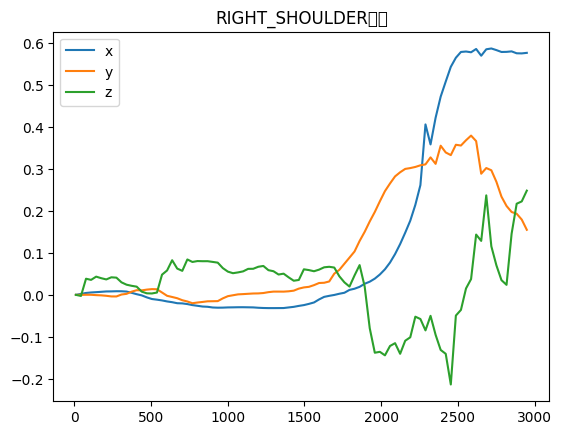

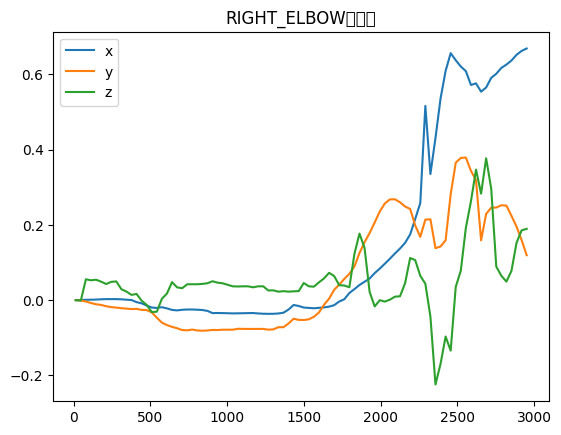

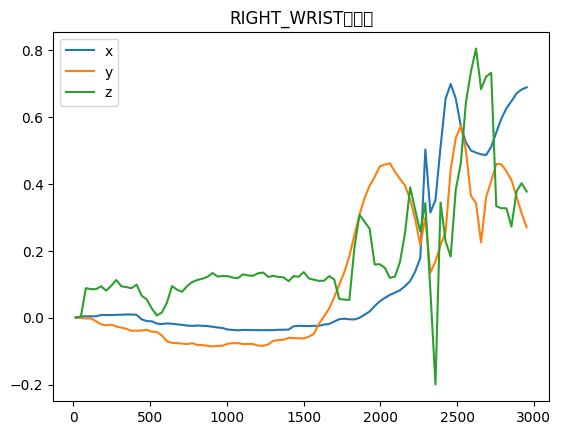

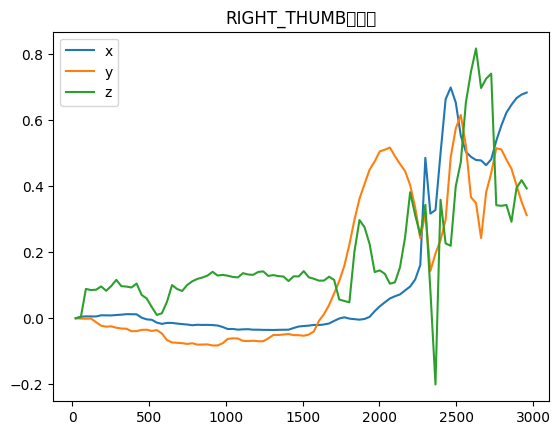

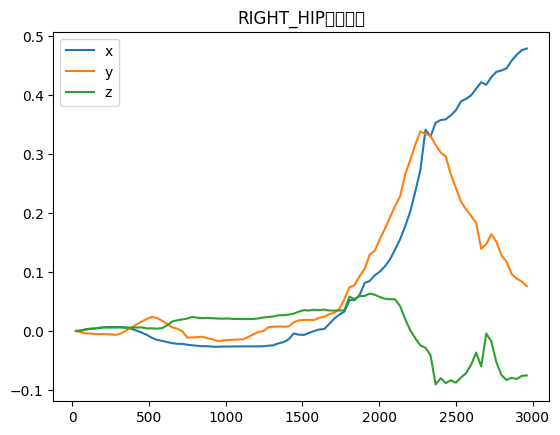

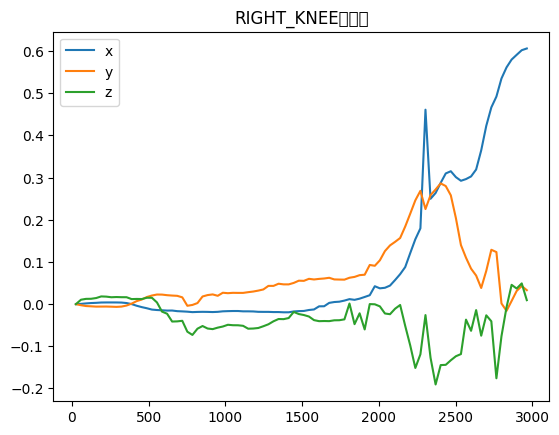

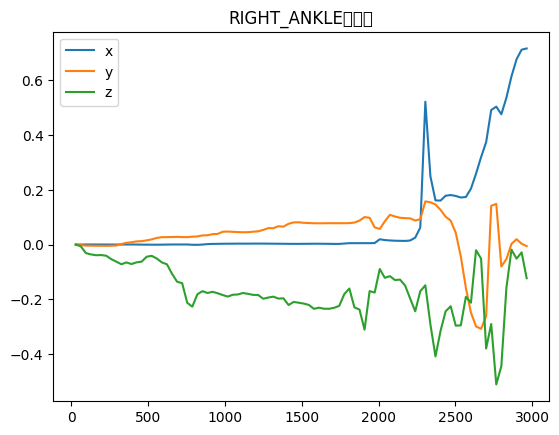

In [21]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # This will suppress all warnings
for i in tag.keys():
    (df.loc[df['joint_id'] == i, 'x'] - df.loc[df['joint_id'] == i, 'x'].iloc[0]).plot(label='x')
    (df.loc[df['joint_id'] == i, 'y'] - df.loc[df['joint_id'] == i, 'y'].iloc[0]).plot(label='y')
    (df.loc[df['joint_id'] == i, 'z'] - df.loc[df['joint_id'] == i, 'z'].iloc[0]).plot(label='z')
    plt.legend()
    plt.title(tag[i])
    plt.show()

In [22]:
# 篩選 joint_id 屬於 tag.keys() 的資料
filtered_df = df[df['joint_id'].isin(tag.keys())]

# 只保留需要的欄位
filtered_df = filtered_df[['frame', 'joint_id', 'x']]

# 建立新的欄位名稱格式為 joint_id(12)_x
filtered_df['joint_x'] = filtered_df['joint_id'].apply(lambda j: f'joint_id({j})_x')

# 使用 pivot 將資料轉換為 index=frame、columns=joint_id 的格式
pivot_df = filtered_df.pivot(index='frame', columns='joint_x', values='x')

# 檢查結果
print(pivot_df.shape)
pivot_df.head()


(90, 7)


joint_x,joint_id(12)_x,joint_id(14)_x,joint_id(16)_x,joint_id(22)_x,joint_id(24)_x,joint_id(26)_x,joint_id(28)_x
frame,,,,,,,
0,0.086249,0.038319,0.073409,0.085778,0.111273,0.107215,0.100603
1,0.088557,0.038753,0.076621,0.090381,0.112230,0.107836,0.100741
2,0.090751,0.039329,0.077278,0.091449,0.113741,0.108926,0.100940
3,0.091917,0.039534,0.077222,0.091310,0.114796,0.109795,0.100945
4,0.092664,0.039916,0.077181,0.091095,0.115602,0.110299,0.100818


<Axes: xlabel='frame'>

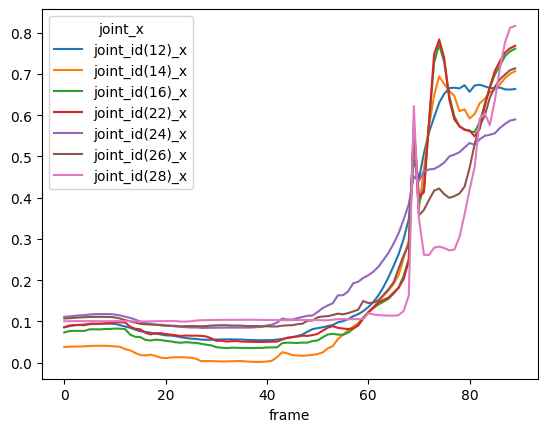

In [23]:
pivot_df.plot()

In [24]:
pivot_df.corr()

joint_x,joint_id(12)_x,joint_id(14)_x,joint_id(16)_x,joint_id(22)_x,joint_id(24)_x,joint_id(26)_x,joint_id(28)_x
joint_x,,,,,,,
joint_id(12)_x,1.000000,0.995615,0.983824,0.979780,0.986298,0.954397,0.853348
joint_id(14)_x,0.995615,1.000000,0.993517,0.990131,0.985519,0.959446,0.861733
joint_id(16)_x,0.983824,0.993517,1.000000,0.999561,0.966429,0.960672,0.876293
joint_id(22)_x,0.979780,0.990131,0.999561,1.000000,0.960274,0.958458,0.876922
joint_id(24)_x,0.986298,0.985519,0.966429,0.960274,1.000000,0.960242,0.860389
joint_id(26)_x,0.954397,0.959446,0.960672,0.958458,0.960242,1.000000,0.962853
joint_id(28)_x,0.853348,0.861733,0.876293,0.876922,0.860389,0.962853,1.000000


# 這裡可以得出結論 感覺上會連動的肌群 他的相關性或許比較高

# 以下針對所有肌群一起做分析

In [25]:
# 篩選 joint_id 屬於 tag.keys() 的資料
filtered_df = df.copy()

# 只保留需要的欄位
filtered_df = filtered_df[['frame', 'joint_id', 'x']]

# 建立新的欄位名稱格式為 joint_id(12)_x
filtered_df['joint_x'] = filtered_df['joint_id'].apply(lambda j: f'joint_id({j})_x')

# 使用 pivot 將資料轉換為 index=frame、columns=joint_id 的格式
pivot_df = filtered_df.pivot(index='frame', columns='joint_x', values='x')

# 檢查結果
print(pivot_df.shape)
pivot_df.head()


(90, 33)


joint_x,joint_id(0)_x,joint_id(1)_x,joint_id(10)_x,joint_id(11)_x,joint_id(12)_x,joint_id(13)_x,joint_id(14)_x,joint_id(15)_x,joint_id(16)_x,joint_id(17)_x,...,joint_id(3)_x,joint_id(30)_x,joint_id(31)_x,joint_id(32)_x,joint_id(4)_x,joint_id(5)_x,joint_id(6)_x,joint_id(7)_x,joint_id(8)_x,joint_id(9)_x
frame,,,,,,,,,,,,,,,,,,,,,
0,0.170223,0.165799,0.160697,0.193108,0.086249,0.211150,0.038319,0.162031,0.073409,0.144161,...,0.167024,0.102454,0.205591,0.098691,0.160432,0.156683,0.152432,0.156000,0.134857,0.166369
1,0.170224,0.165798,0.160729,0.193533,0.088557,0.209401,0.038753,0.161565,0.076621,0.143377,...,0.167036,0.102714,0.206167,0.098690,0.160434,0.156688,0.152469,0.156121,0.135042,0.166525
2,0.170240,0.165859,0.160773,0.194535,0.090751,0.207724,0.039329,0.159796,0.077278,0.142198,...,0.167364,0.103175,0.206404,0.098684,0.160439,0.156691,0.152513,0.157109,0.135304,0.167032
3,0.170348,0.166087,0.160792,0.195422,0.091917,0.207173,0.039534,0.158390,0.077222,0.140069,...,0.167925,0.103173,0.206537,0.098689,0.160505,0.156757,0.152623,0.157919,0.135533,0.167392
4,0.170447,0.166359,0.160839,0.196056,0.092664,0.207153,0.039916,0.157493,0.077181,0.137419,...,0.168763,0.102671,0.206430,0.098694,0.160509,0.156762,0.152626,0.159389,0.135642,0.168143


<Axes: xlabel='frame'>

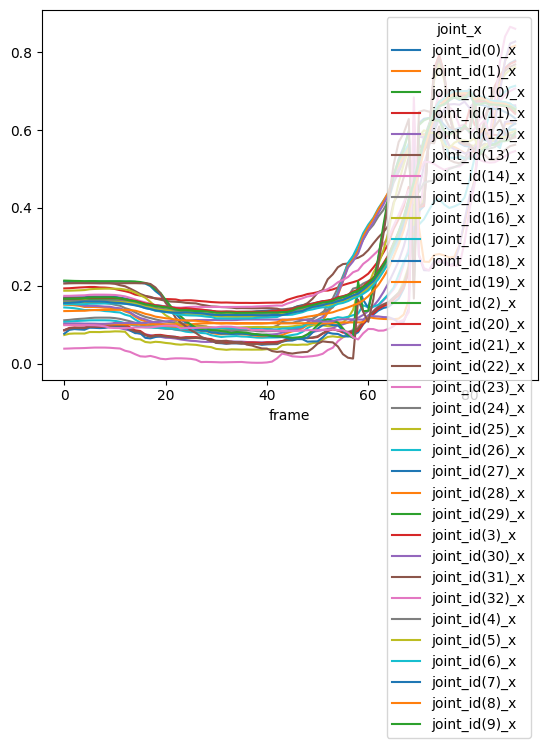

In [26]:
pivot_df.plot()

In [27]:
pivot_df.corr().style.background_gradient()

joint_x,joint_id(0)_x,joint_id(1)_x,joint_id(10)_x,joint_id(11)_x,joint_id(12)_x,joint_id(13)_x,joint_id(14)_x,joint_id(15)_x,joint_id(16)_x,joint_id(17)_x,joint_id(18)_x,joint_id(19)_x,joint_id(2)_x,joint_id(20)_x,joint_id(21)_x,joint_id(22)_x,joint_id(23)_x,joint_id(24)_x,joint_id(25)_x,joint_id(26)_x,joint_id(27)_x,joint_id(28)_x,joint_id(29)_x,joint_id(3)_x,joint_id(30)_x,joint_id(31)_x,joint_id(32)_x,joint_id(4)_x,joint_id(5)_x,joint_id(6)_x,joint_id(7)_x,joint_id(8)_x,joint_id(9)_x
joint_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
joint_id(0)_x,1.000000,0.999935,0.999965,0.996063,0.998387,0.958657,0.992451,0.933469,0.979305,0.920260,0.972280,0.931248,0.999911,0.972415,0.935769,0.975217,0.979501,0.984829,0.964550,0.942048,0.935576,0.831587,0.931759,0.999878,0.808691,0.919447,0.798765,0.999913,0.999873,0.999822,0.999781,0.999634,0.999955
joint_id(1)_x,0.999935,1.000000,0.999878,0.995714,0.998337,0.957936,0.992361,0.933015,0.979112,0.919883,0.972095,0.930918,0.999995,0.972222,0.935420,0.975028,0.978732,0.984008,0.963461,0.940335,0.934917,0.828994,0.931203,0.999978,0.806195,0.918875,0.795997,0.999973,0.999945,0.999902,0.999913,0.999748,0.999869
joint_id(10)_x,0.999965,0.999878,1.000000,0.995995,0.998602,0.958602,0.992678,0.933611,0.979669,0.920432,0.972686,0.931424,0.999848,0.972823,0.935940,0.975605,0.979654,0.985458,0.964696,0.943999,0.935565,0.834819,0.931654,0.999807,0.812082,0.919447,0.802197,0.999882,0.999856,0.999819,0.999710,0.999663,0.999959
joint_id(11)_x,0.996063,0.995714,0.995995,1.000000,0.991584,0.976614,0.983677,0.955033,0.965225,0.943659,0.955962,0.952601,0.995806,0.956367,0.956360,0.960037,0.990364,0.988165,0.978327,0.932346,0.953218,0.813087,0.950363,0.995906,0.787960,0.938056,0.777734,0.995299,0.995049,0.994775,0.995952,0.994070,0.996503
joint_id(12)_x,0.998387,0.998337,0.998602,0.991584,1.000000,0.949975,0.995615,0.925064,0.983824,0.911660,0.977278,0.923182,0.998271,0.977187,0.927922,0.979780,0.975442,0.986298,0.955217,0.954397,0.922380,0.853348,0.917902,0.998191,0.832548,0.905166,0.822743,0.998532,0.998606,0.998673,0.998145,0.998832,0.998316
joint_id(13)_x,0.958657,0.957936,0.958602,0.976614,0.949975,1.000000,0.947771,0.992937,0.923089,0.987502,0.909695,0.990167,0.958363,0.910826,0.991807,0.916039,0.990404,0.973285,0.982233,0.889976,0.964458,0.751983,0.961915,0.958816,0.722461,0.949013,0.714256,0.956522,0.955866,0.955107,0.958875,0.952906,0.960497
joint_id(14)_x,0.992451,0.992361,0.992678,0.983677,0.995615,0.947771,1.000000,0.927075,0.993517,0.914809,0.988238,0.925723,0.992308,0.988038,0.930505,0.990131,0.972746,0.985519,0.947553,0.959446,0.910010,0.861733,0.904082,0.992227,0.842034,0.890362,0.833597,0.992401,0.992445,0.992469,0.992042,0.992535,0.992534
joint_id(15)_x,0.933469,0.933015,0.933611,0.955033,0.925064,0.992937,0.927075,1.000000,0.898439,0.999070,0.882964,0.999566,0.933629,0.884027,0.999652,0.889996,0.980685,0.960981,0.968804,0.869629,0.950773,0.728834,0.947646,0.934261,0.699980,0.934858,0.690493,0.931212,0.930464,0.929578,0.934569,0.927234,0.935926
joint_id(16)_x,0.979305,0.979112,0.979669,0.965225,0.983824,0.923089,0.993517,0.898439,1.000000,0.884333,0.999106,0.896522,0.978907,0.999050,0.902472,0.999561,0.948590,0.966429,0.927190,0.960672,0.889263,0.876293,0.882036,0.978648,0.857705,0.870038,0.852876,0.979415,0.979583,0.979732,0.978087,0.980023,0.979213


# joint_id(28)_x joint_id(30)_x joint_id(32)_x 比較特別

# 為了去除共線性 我們就挑28 30 32這三個相關性比較低的特徵 + 一個相關性比較高的特徵(可以代表其他特徵)

In [28]:
pivot_df.corr().sum().sort_values(ascending=False).head(1).index[0]

'joint_id(9)_x'

In [29]:
pivot_df[['joint_id(9)_x','joint_id(28)_x','joint_id(30)_x','joint_id(32)_x']].corr()

joint_x,joint_id(9)_x,joint_id(28)_x,joint_id(30)_x,joint_id(32)_x
joint_x,,,,
joint_id(9)_x,1.000000,0.832141,0.809151,0.799312
joint_id(28)_x,0.832141,1.000000,0.998014,0.996572
joint_id(30)_x,0.809151,0.998014,1.000000,0.996891
joint_id(32)_x,0.799312,0.996572,0.996891,1.000000


# 這裡看出 保留9跟 28 即可

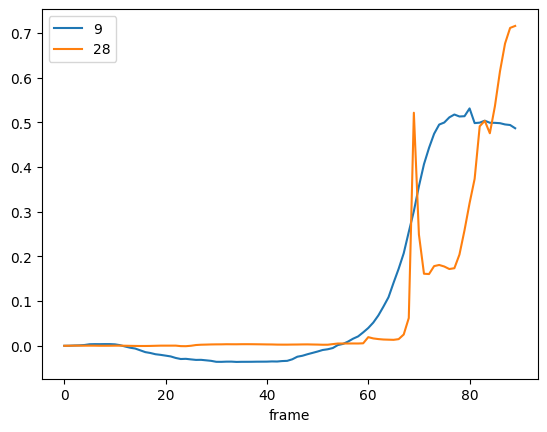

In [30]:
(pivot_df['joint_id(9)_x'] - pivot_df['joint_id(9)_x'].iloc[0]).plot(label='9')
(pivot_df['joint_id(28)_x'] - pivot_df['joint_id(28)_x'].iloc[0]).plot(label='28')
plt.legend()
plt.show()

# 這裡嘗試分析不同影片的'joint_id(9)_x','joint_id(28)_x'

In [31]:
generate_pose_data('../raw_video/videoplayback (1).mp4','data1.csv')

儲存完成: data1.csv


In [32]:
# 篩選 joint_id 屬於 tag.keys() 的資料
filtered_df = pd.read_csv('data1.csv').copy()

# 只保留需要的欄位
filtered_df = filtered_df[['frame', 'joint_id', 'x']]

# 建立新的欄位名稱格式為 joint_id(12)_x
filtered_df['joint_x'] = filtered_df['joint_id'].apply(lambda j: f'joint_id({j})_x')

# 使用 pivot 將資料轉換為 index=frame、columns=joint_id 的格式
pivot_df = filtered_df.pivot(index='frame', columns='joint_x', values='x')

# 檢查結果
print(pivot_df.shape)
pivot_df.head()


(199, 33)


joint_x,joint_id(0)_x,joint_id(1)_x,joint_id(10)_x,joint_id(11)_x,joint_id(12)_x,joint_id(13)_x,joint_id(14)_x,joint_id(15)_x,joint_id(16)_x,joint_id(17)_x,...,joint_id(3)_x,joint_id(30)_x,joint_id(31)_x,joint_id(32)_x,joint_id(4)_x,joint_id(5)_x,joint_id(6)_x,joint_id(7)_x,joint_id(8)_x,joint_id(9)_x
frame,,,,,,,,,,,,,,,,,,,,,
0,0.445852,0.439447,0.437431,0.285187,0.461818,0.266104,0.512237,0.351118,0.467685,0.366479,...,0.430432,0.479512,0.357421,0.505214,0.442890,0.441476,0.440262,0.404195,0.419484,0.432957
1,0.445065,0.437985,0.437364,0.284990,0.463236,0.271177,0.510939,0.350315,0.470524,0.360137,...,0.429732,0.480540,0.356941,0.496056,0.441196,0.440043,0.439114,0.403866,0.418824,0.432762
2,0.444680,0.437188,0.437344,0.284740,0.463579,0.272860,0.510318,0.348873,0.471128,0.356068,...,0.429397,0.480557,0.355164,0.490792,0.440192,0.439113,0.438272,0.403652,0.417982,0.432717
3,0.444237,0.436135,0.437345,0.284642,0.463589,0.273010,0.509257,0.346669,0.470959,0.351756,...,0.428250,0.480419,0.353652,0.484380,0.439655,0.438785,0.438123,0.403097,0.418109,0.432555
4,0.443201,0.434598,0.437065,0.284392,0.463966,0.272820,0.506356,0.345919,0.469120,0.351164,...,0.426314,0.479703,0.353625,0.480574,0.438715,0.438069,0.437625,0.401602,0.418106,0.431517


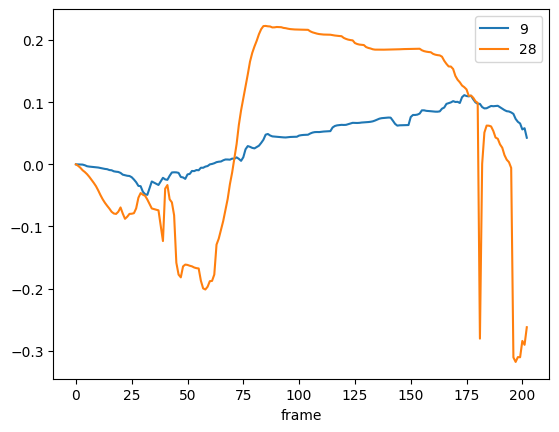

In [33]:
import matplotlib.pyplot as plt
(pivot_df['joint_id(9)_x'] - pivot_df['joint_id(9)_x'].iloc[0]).plot(label='9')
(pivot_df['joint_id(28)_x'] - pivot_df['joint_id(28)_x'].iloc[0]).plot(label='28')
plt.legend()
plt.show()

# 結論不同影片 的數據差異非常大
# 但是變化的方向大致類似